In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,73888,None,None,86085.715275
2020-06-13,73889,None,None,79940.811469
2020-06-14,73890,None,None,74244.112992
2020-06-15,73891,None,None,68878.187593
2020-06-16,73892,None,None,64137.552455
...,...,...,...,...
2021-06-26,74267,None,None,274911.482075
2021-06-27,74268,None,None,284753.271201
2021-06-28,74269,None,None,294599.522884


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-06-30_2021-06-30-18-30.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-06-29_2021-06-29-22-21.pickle


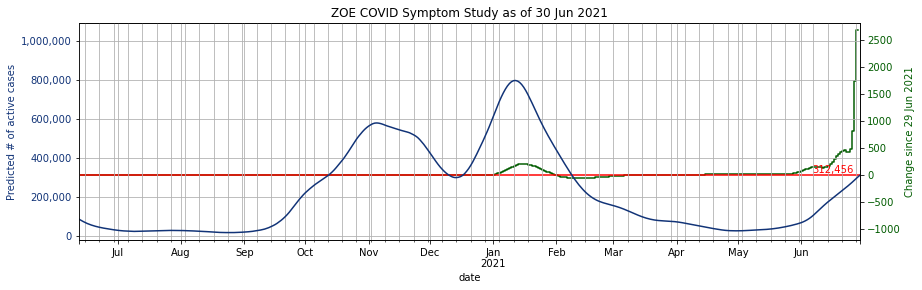

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

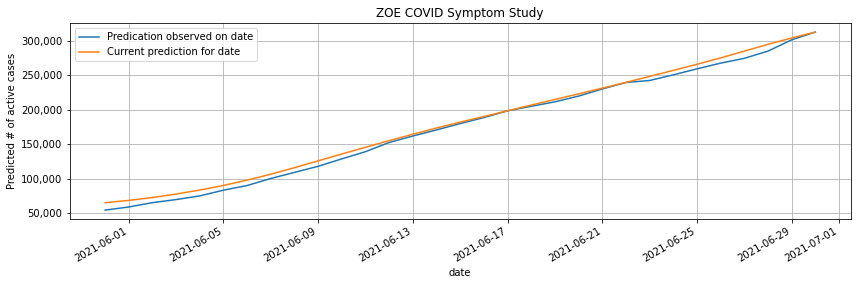

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-06-30_2021-06-30-18-30.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
390,Dundee City,S12000042,3.310582
325,Glasgow City,S12000046,2.443061
295,East Renfrewshire,S12000011,2.007535
268,Oldham,E08000004,1.935975
100,Erewash,E07000036,1.769401
317,Renfrewshire,S12000038,1.681946
316,City of Edinburgh,S12000036,1.541107
276,Liverpool,E08000012,1.458920
293,East Lothian,S12000010,1.434775
267,Bury,E08000002,1.417840
